In [12]:
from pymongo import MongoClient
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from bson import ObjectId
import random
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


# Connect to MongoDB
client = MongoClient('mongodb://localhost:27017')
db = client['collaborativefilteringtest']  # Database name
users_collection = db['users']
posts_collection = db['posts']
likes_collection = db['likes']
answers_collection = db['answers']  # Add answers collection    


In [13]:
def predict_rating(user_idx, post_idx, train_matrix, user_similarity):
    sim_scores = user_similarity[user_idx]
    item_ratings = train_matrix[:, post_idx]
    non_zero_ratings = item_ratings[item_ratings != 0]

    weighted_sum = 0
    similarity_sum = 0
    for idx in range(len(non_zero_ratings)):
        similarity = sim_scores[idx]
        weighted_sum += similarity * item_ratings[idx]
        similarity_sum += similarity

    if similarity_sum == 0:
        return 0
    return weighted_sum / similarity_sum

query='hukum'
def train_search_model(query):
    # Fetch data from MongoDB
    users = list(users_collection.find())
    search_query = {
        "$or": [
            { "date": { "$regex": query, "$options": "i" } },
            { "question": { "$regex": query, "$options": "i" } },
            { "topic": { "$regex": query, "$options": "i" } },
            { "id_user": { "$regex": query, "$options": "i" } },
            { "title": { "$regex": query, "$options": "i" } },
            { "post_pic": { "$regex": query, "$options": "i" } }
        ]
    }
    posts = list(posts_collection.find(search_query))

    if not posts:
        posts = list(posts_collection.find())
        
    # Get likes for filtered posts
    post_ids = [str(post['_id']) for post in posts]
    likes = list(likes_collection.find({'post_id': {'$in': post_ids}}))
    # Get answers for filtered posts
    answers = list(answers_collection.find({'post_id': {'$in': post_ids}}))


     # Create mappings for user and post IDs (using string IDs)
    user_ids = {str(user['_id']): idx for idx, user in enumerate(users)}
    post_ids = {str(post['_id']): idx for idx, post in enumerate(posts)}

    print('post_id: ', post_ids , 'user_ids: ', user_ids)

    # Create rating matrix
    num_users = len(users)
    num_posts = len(posts)
    ratings_matrix = np.zeros((num_users, num_posts))

    for like in likes:
        user_id_str = str(like['user_id'])
        post_id_str = str(like['post_id'])
        
        # Debug output: Check if the ID exists in the mappings
        if user_id_str not in user_ids:
            print(f"User ID {user_id_str} not found in user_ids mapping")
        if post_id_str not in post_ids:
            print(f"Post ID {post_id_str} not found in post_ids mapping")

        user_idx = user_ids[user_id_str]
        post_idx = post_ids[post_id_str]
        
        ratings_matrix[user_idx, post_idx] = 1

    for answer in answers:
        user_id_str = str(answer['user_id'])
        post_id_str = str(answer['post_id'])
        
        # Debug output: Check if the ID exists in the mappings
        if user_id_str not in user_ids:
            print(f"User ID {user_id_str} not found in user_ids mapping")
        if post_id_str not in post_ids:
            print(f"Post ID {post_id_str} not found in post_ids mapping")

        user_idx = user_ids[user_id_str]
        post_idx = post_ids[post_id_str]
        
        ratings_matrix[user_idx, post_idx] = 1

    def create_train_test_split(ratings_matrix, test_size=0.2):
        num_users, num_posts = ratings_matrix.shape
        # Create an empty matrix for train and test
        train_matrix = np.copy(ratings_matrix)
        test_matrix = np.zeros_like(ratings_matrix)

        for user in range(num_users):
            # Find the indices of non-zero entries (interactions) for the current user
            non_zero_indices = np.nonzero(ratings_matrix[user])[0]
            
            if len(non_zero_indices) < 2:
                continue  # Skip users with less than two interactions
            
            # Split indices into train and test
            train_indices, test_indices = train_test_split(non_zero_indices, test_size=test_size, random_state=42)
            
            # Update train and test matrices
            train_matrix[user, train_indices] = ratings_matrix[user, train_indices]
            test_matrix[user, test_indices] = ratings_matrix[user, test_indices]

        return train_matrix, test_matrix

    # Train-test split
    train_matrix, test_matrix = create_train_test_split(ratings_matrix, test_size=0.2)

    # Visualize the ratings matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(train_matrix, cmap='YlGnBu', cbar=True)
    plt.title('Training Ratings Matrix')
    plt.xlabel('Posts')
    plt.ylabel('Users')
    plt.show()

    # Calculate cosine similarity between users
    user_similarity = cosine_similarity(train_matrix)
    print('------------------------------------------------------')
    print('user similarity shape: ', user_similarity.shape)
    print('user similarity: ', user_similarity)
    print('------------------------------------------------------')

    # Visualize the user similarity matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(user_similarity, cmap='coolwarm', cbar=True)
    plt.title('User Similarity Matrix')
    plt.xlabel('Users')
    plt.ylabel('Users')
    plt.show()
    
    # Function to recommend posts for a given user based on similar users' likes
    def recommend_posts(user_idx, num_recommendations=5):
        print('Processing recommendations for user index:', user_idx)
        sim_scores = user_similarity[user_idx]
        print('sim_scores: ', sim_scores)
        print('------------------------------------------------------')
        
        similar_users = np.argsort(sim_scores)[::-1][1:]  # Exclude the user itself
        print('similar users: ', similar_users)
        print('------------------------------------------------------')
        
        post_scores = np.zeros(num_posts)
    
        for similar_user in similar_users:
            post_scores += sim_scores[similar_user] * train_matrix[similar_user]
            print('post score: ', post_scores)
            print('------------------------------------------------------')

        print('post score rate: ',  post_scores[train_matrix[user_idx] > 0])
        print('------------------------------------------------------')
        post_scores[train_matrix[user_idx] > 0] = 0
        print('post score filter: ',  post_scores[train_matrix[user_idx] > 0])
        print('------------------------------------------------------')
        recommended_post_indices = np.argsort(post_scores)[::-1][:num_recommendations]
        return recommended_post_indices

    # Generate recommendations for all users and save to a dictionary
    recommendations = {}
    for user_id_str, user_idx in user_ids.items():
        if user_idx >= user_similarity.shape[0]:
            print(f"User index {user_idx} is out of bounds for user_similarity with shape {user_similarity.shape}")
            continue
        recommended_posts = recommend_posts(user_idx, num_recommendations=5)
        print('------------------------------------------------------')
        print('search_recommended posts: ', recommended_posts)
        print('------------------------------------------------------')
        recommended_post_ids = [list(post_ids.keys())[list(post_ids.values()).index(post_idx)] for post_idx in recommended_posts]
        recommendations[user_id_str] = recommended_post_ids

    # Save recommendations to a JSON file
    with open('search_recommendations.json', 'w') as f:
        json.dump(recommendations, f)

    # Evaluate model
    actual_ratings = []
    predicted_ratings = []

    for user_idx in range(len(test_matrix)):
        for post_idx in range(num_posts):
            if test_matrix[user_idx, post_idx] != 0:
                actual_ratings.append(test_matrix[user_idx, post_idx])
                predicted_ratings.append(predict_rating(user_idx, post_idx, train_matrix, user_similarity))

    mae = mean_absolute_error(actual_ratings, predicted_ratings)
    print(f'Mean Absolute Error: {mae}')

    return train_matrix, recommendations, user_similarity


In [14]:
# Load recommendations from JSON file
with open('search_recommendations.json', 'r') as f:
    recommendations = json.load(f)

# Convert recommendations to a pandas DataFrame for analysis
recommendations_df = pd.DataFrame.from_dict(recommendations, orient='index')
recommendations_df.columns = [f'Recommendation_{i+1}' for i in range(recommendations_df.shape[1])]
recommendations_df.reset_index(inplace=True)
recommendations_df.rename(columns={'index': 'User_ID'}, inplace=True)

# Display the first few rows of the recommendations DataFrame
recommendations_df.head()


,User_ID,Recommendation_1,Recommendation_2,Recommendation_3,Recommendation_4,Recommendation_5
0,669c0b8e2ea43ac3b0c83bd2,6701a1a1a1a1a1a1a1a1a1a1,6701a1a1a1a1a1a1a1a1a1b1,6701a1a1a1a1a1a1a1a1a1ac,6701a1a1a1a1a1a1a1a1a1bb,6701a1a1a1a1a1a1a1a1a1b4
1,669c0b8e2ea43ac3b0c83bd3,6701a1a1a1a1a1a1a1a1a1aa,6701a1a1a1a1a1a1a1a1a1ac,6701a1a1a1a1a1a1a1a1a1b6,6701a1a1a1a1a1a1a1a1a1c8,6701a1a1a1a1a1a1a1a1a1be
2,669c0b8e2ea43ac3b0c83bd4,6701a1a1a1a1a1a1a1a1a1a2,6701a1a1a1a1a1a1a1a1a1c0,6701a1a1a1a1a1a1a1a1a1c4,6701a1a1a1a1a1a1a1a1a1b2,6701a1a1a1a1a1a1a1a1a1aa
3,669c0b8e2ea43ac3b0c83bd5,6701a1a1a1a1a1a1a1a1a1c8,6701a1a1a1a1a1a1a1a1a1c5,6701a1a1a1a1a1a1a1a1a1bb,6701a1a1a1a1a1a1a1a1a1be,6701a1a1a1a1a1a1a1a1a1bf
4,669c0b8e2ea43ac3b0c83bd6,6701a1a1a1a1a1a1a1a1a1aa,6701a1a1a1a1a1a1a1a1a1c5,6701a1a1a1a1a1a1a1a1a1b4,6701a1a1a1a1a1a1a1a1a1be,6701a1a1a1a1a1a1a1a1a1bf


In [15]:
def visualize_recommendations(recommendations):
    # Load recommendations into a DataFrame
    recommendations_df = pd.DataFrame.from_dict(recommendations, orient='index')

    # Distribution of unique recommendations per user
    unique_recommendations_count = recommendations_df.apply(lambda x: len(set(x.dropna())), axis=1)

    plt.figure(figsize=(12, 6))
    sns.histplot(unique_recommendations_count, kde=False, bins=30)
    plt.xlabel('Number of Unique Recommendations per User')
    plt.ylabel('Number of Users')
    plt.title('Distribution of Unique Recommendations per User')
    plt.show()

    # Review recommendations for a few specific users
    user_sample = random.sample(list(recommendations.keys()), 5)
    for user_id in user_sample:
        print(f"Recommendations for user {user_id}: {recommendations[user_id]}")

    # Analyze post popularity in recommendations
    all_recommendations = recommendations_df.values.flatten()
    post_counts = pd.Series(all_recommendations).value_counts()

    plt.figure(figsize=(12, 6))
    sns.histplot(post_counts, bins=30, kde=False)
    plt.xlabel('Number of Recommendations per Post')
    plt.ylabel('Number of Posts')
    plt.title('Distribution of Recommendations per Post')
    plt.show()

post_id:  {'6701a1a1a1a1a1a1a1a1a1a2': 0, '6701a1a1a1a1a1a1a1a1a1a9': 1, '6701a1a1a1a1a1a1a1a1a1ac': 2, '6701a1a1a1a1a1a1a1a1a1c1': 3} user_ids:  {'669c0b8e2ea43ac3b0c83bd2': 0, '669c0b8e2ea43ac3b0c83bd3': 1, '669c0b8e2ea43ac3b0c83bd4': 2, '669c0b8e2ea43ac3b0c83bd5': 3, '669c0b8e2ea43ac3b0c83bd6': 4, '669c0b8e2ea43ac3b0c83bd7': 5, '669c0b8e2ea43ac3b0c83bd8': 6, '669c0b8e2ea43ac3b0c83bd9': 7, '669c0b8e2ea43ac3b0c83bda': 8, '669c0b8e2ea43ac3b0c83bdb': 9, '669c0b8e2ea43ac3b0c83bdc': 10, '669c0bb23cfd9ea81c694fc8': 11, '669c0b8e2ea43ac3b0c83bdd': 12, '669c0b8e2ea43ac3b0c83be4': 13, '66a0ae5660cb65cbc9feb870': 14}


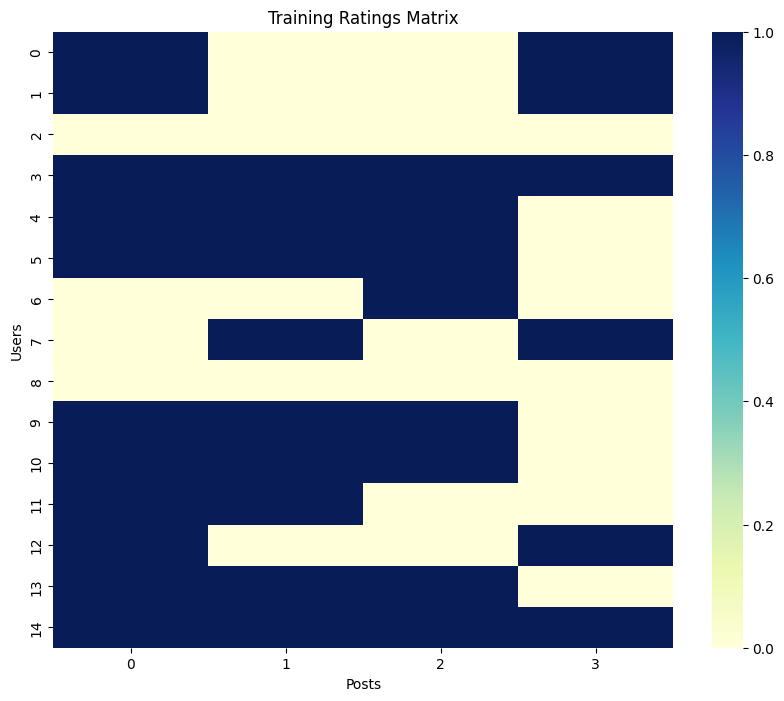

------------------------------------------------------
user similarity shape:  (15, 15)
user similarity:  [[1.         1.         0.         0.70710678 0.40824829 0.40824829
  0.         0.5        0.         0.40824829 0.40824829 0.5
  1.         0.40824829 0.70710678]
 [1.         1.         0.         0.70710678 0.40824829 0.40824829
  0.         0.5        0.         0.40824829 0.40824829 0.5
  1.         0.40824829 0.70710678]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.        ]
 [0.70710678 0.70710678 0.         1.         0.8660254  0.8660254
  0.5        0.70710678 0.         0.8660254  0.8660254  0.70710678
  0.70710678 0.8660254  1.        ]
 [0.40824829 0.40824829 0.         0.8660254  1.         1.
  0.57735027 0.40824829 0.         1.         1.         0.81649658
  0.40824829 1.         0.8660254 ]
 [0.40824829 0.40824829 0.         0.8660254  1.         1.
  0.57735027 

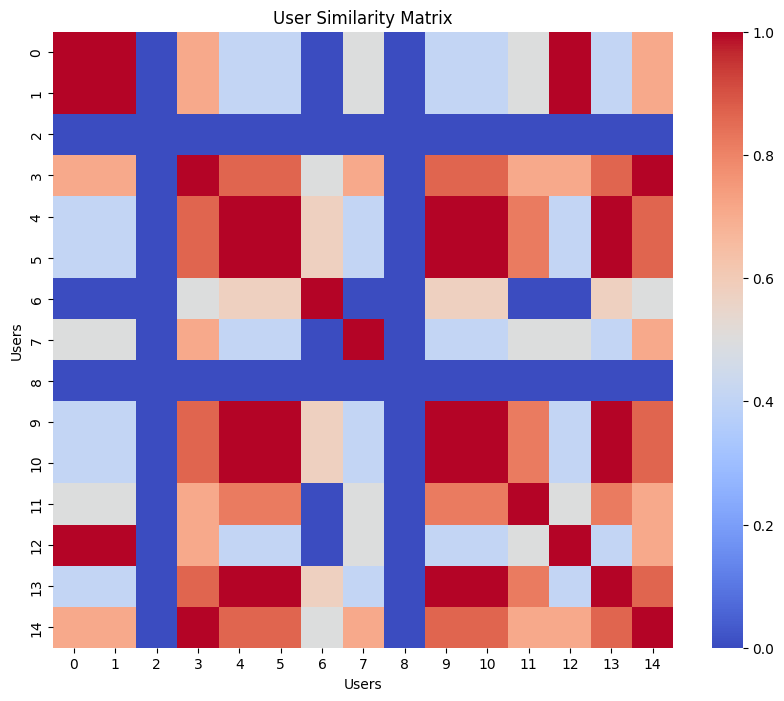

Processing recommendations for user index: 0
sim_scores:  [1.         1.         0.         0.70710678 0.40824829 0.40824829
 0.         0.5        0.         0.40824829 0.40824829 0.5
 1.         0.40824829 0.70710678]
------------------------------------------------------
similar users:  [ 0  1 14  3  7 11  5  9 10 13  4  8  6  2]
------------------------------------------------------
post score:  [1. 0. 0. 1.]
------------------------------------------------------
post score:  [2. 0. 0. 2.]
------------------------------------------------------
post score:  [2.70710678 0.70710678 0.70710678 2.70710678]
------------------------------------------------------
post score:  [3.41421356 1.41421356 1.41421356 3.41421356]
------------------------------------------------------
post score:  [3.41421356 1.91421356 1.41421356 3.91421356]
------------------------------------------------------
post score:  [3.91421356 2.41421356 1.41421356 3.91421356]
---------------------------------------------

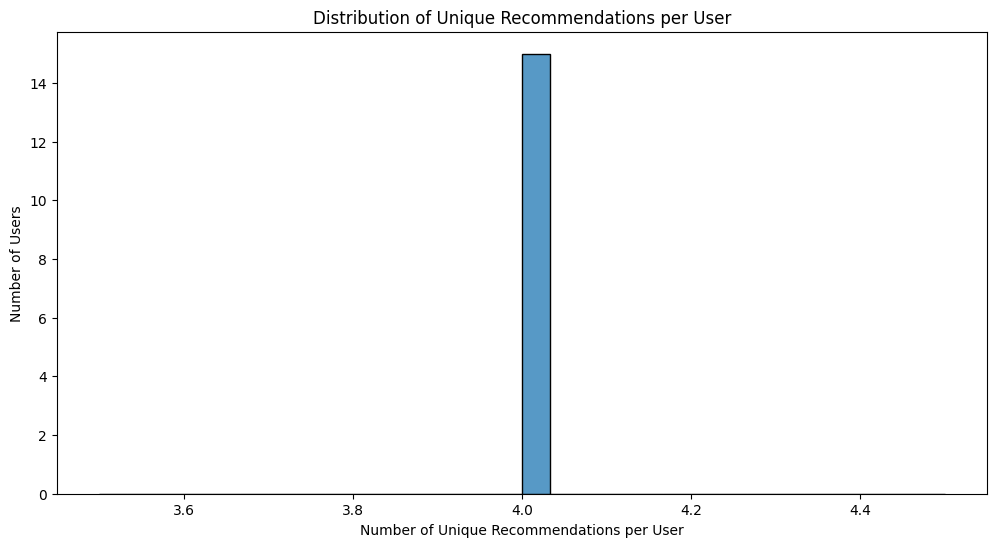

Recommendations for user 669c0b8e2ea43ac3b0c83bda: ['6701a1a1a1a1a1a1a1a1a1c1', '6701a1a1a1a1a1a1a1a1a1ac', '6701a1a1a1a1a1a1a1a1a1a9', '6701a1a1a1a1a1a1a1a1a1a2']
Recommendations for user 669c0b8e2ea43ac3b0c83bd3: ['6701a1a1a1a1a1a1a1a1a1a9', '6701a1a1a1a1a1a1a1a1a1ac', '6701a1a1a1a1a1a1a1a1a1c1', '6701a1a1a1a1a1a1a1a1a1a2']
Recommendations for user 669c0b8e2ea43ac3b0c83bd4: ['6701a1a1a1a1a1a1a1a1a1c1', '6701a1a1a1a1a1a1a1a1a1ac', '6701a1a1a1a1a1a1a1a1a1a9', '6701a1a1a1a1a1a1a1a1a1a2']
Recommendations for user 669c0b8e2ea43ac3b0c83bd2: ['6701a1a1a1a1a1a1a1a1a1a9', '6701a1a1a1a1a1a1a1a1a1ac', '6701a1a1a1a1a1a1a1a1a1c1', '6701a1a1a1a1a1a1a1a1a1a2']
Recommendations for user 669c0b8e2ea43ac3b0c83bdd: ['6701a1a1a1a1a1a1a1a1a1a9', '6701a1a1a1a1a1a1a1a1a1ac', '6701a1a1a1a1a1a1a1a1a1c1', '6701a1a1a1a1a1a1a1a1a1a2']


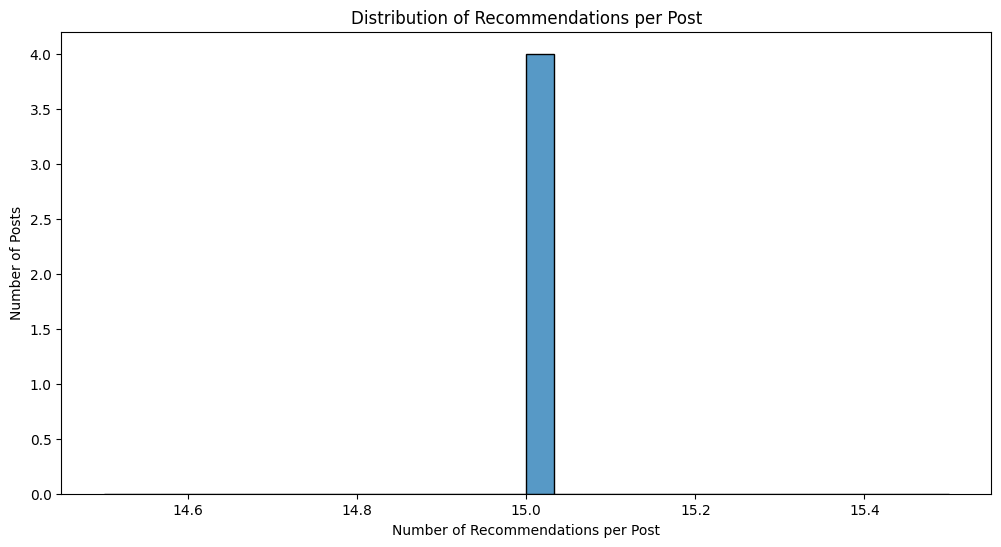

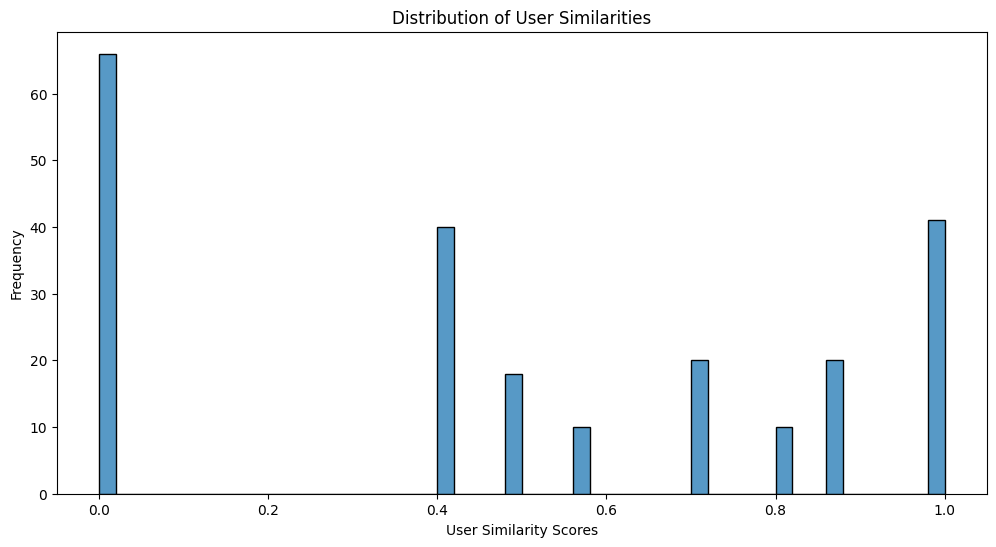

In [16]:
def visualize_user_similarity(user_similarity):
    # Distribution of user similarities
    similarity_scores = user_similarity.flatten()
    plt.figure(figsize=(12, 6))
    sns.histplot(similarity_scores, bins=50, kde=False)
    plt.xlabel('User Similarity Scores')
    plt.ylabel('Frequency')
    plt.title('Distribution of User Similarities')
    plt.show()

# Train the model
query='hukum'
train_matrix, recommendations, user_similarity = train_search_model(query)

# Visualize the recommendations and user similarities
visualize_recommendations(recommendations)
visualize_user_similarity(user_similarity)